In [ ]:
#Using NLTK
#VADER (Valence Aware Dictionary and SEntiment Reasoner) - Bag of words approach (Traditional)
# Roberta Pretrained Model from Huggingface Pipeline
#DATASET- Amazon fine food reviews
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
nltk.download('punkt')
plt.style.use('ggplot')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df=pd.read_csv('Reviews.csv')
df.head(10)
#Score is 1-5 star rating, running sentiment analysis on the Text column

ParserError: Error tokenizing data. C error: EOF inside string starting at row 503631

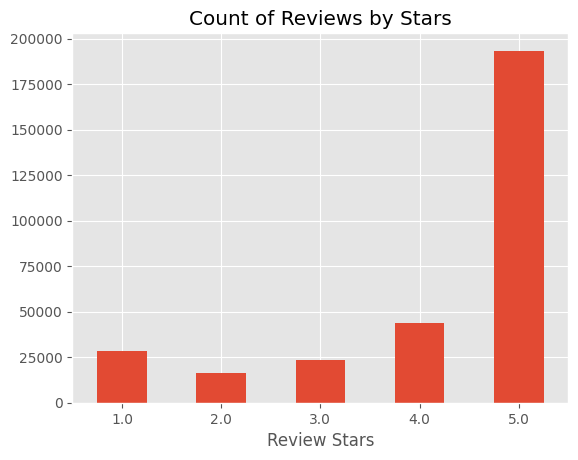

In [ ]:
#EDA
graph = df['Score'].value_counts().sort_index().plot(kind='bar',title='Count of Reviews by Stars')
graph.set_xlabel('Review Stars')
plt.xticks(rotation=0)
plt.show()
#Sort_index sorts the indexes numerically or alphabetically

In [ ]:
example=df['Text'][50]
print(example)
#Using NLTK
#Tokenizing the sentence
tokens=nltk.word_tokenize(example) #Better than splitting the text by space, it splits using words and punctuations
tokens[:10]


This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [ ]:
#It'll identify parts of speech
#Refer Penn Treebank POS Tags for identifying the tags
nltk.download('averaged_perceptron_tagger')
tagged=nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [ ]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()#Will take these tokens and group them
#Takes the POS-tagged tokens and performs named entity recognition.

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


**VADER SENTIMENT SCORING**

In [ ]:
#VADER- Valence Aware Dictionary and Sentiment Reasoner
#It'll give a positive,negative or neutral score to all the words
#And combine all of them to give a net +/-/0 to tell how positive or negative is the overall sentence
#This will not account for the relationship between the words and remove stop words like and/or/the
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm #Used for tracking the progress

sia=SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
sia.polarity_scores('I am so stressed up.')#Compound is the aggregate of the scores

{'neg': 0.473, 'neu': 0.527, 'pos': 0.0, 'compound': -0.4005}

In [ ]:
sia.polarity_scores('My mom gave me a chocolate to lift my spirits and brighten my mood.')

{'neg': 0.0, 'neu': 0.805, 'pos': 0.195, 'compound': 0.4404}

In [ ]:
sia.polarity_scores('I was having a good day until the results were out.')

{'neg': 0.0, 'neu': 0.734, 'pos': 0.266, 'compound': 0.4404}

In [ ]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [ ]:
#Run the polarity scores on the entire dataset
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    if isinstance(text, str):
        res[myid] = sia.polarity_scores(text)
    else:
        print(f"Skipping row {myid} due to invalid text.")
# df.iterrows() is a Pandas method that iterates over the DataFrame rows as (index, Series) pairs.


  0%|          | 0/305311 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(res)#Wrong presentation
vaders=pd.DataFrame(res).T
print(vaders)
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
print(vaders)
vaders = vaders.merge(df, how='left')
print(vaders)

In [ ]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

In [ ]:
#Making 3 bar graphs for positives, neutrals and negatives
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

** ROBERTA PRE-TRAINED MODEL**

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [ ]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687465, 'roberta_pos': 0.0029573692}


In [ ]:
def polarity_scores_roberta(example):
  encoded_text=tokenizer(example, return_tensors='pt')
  output=model(**encoded_text)
  scores=output[0][0].detach().numpy()
  scores=softmax(scores)
  scores_dict={
      'roberta_neg' : scores[0],
      'roberta_neu' : scores[1],
     'roberta_pos' : scores[2]
  }
  return scores_dict



In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)

        roberta_result = polarity_scores_roberta(text)
        break

  0%|          | 0/305311 [00:00<?, ?it/s]

In [ ]:
vader_result

{'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441}

In [ ]:
roberta_result

{'roberta_neg': 0.009624235,
 'roberta_neu': 0.049980413,
 'roberta_pos': 0.94039536}

In [ ]:
#Combine both the dictionaries
{**vader_result, **roberta_result}

{'neg': 0.0,
 'neu': 0.695,
 'pos': 0.305,
 'compound': 0.9441,
 'roberta_neg': 0.009624235,
 'roberta_neu': 0.049980413,
 'roberta_pos': 0.94039536}

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), 10000):
  try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename={}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both={**vader_result, **roberta_result}
        res[myid]=both
  except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/305311 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540


KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

**COMPARE SCORES BETWEEN TWO MODELS**

In [ ]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]


In [ ]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

**EXTRA**

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")
sent_pipeline('I love sentiment analysis!')

**FINE-TUNING ROBERTA MODEL**

In [ ]:
import pandas as pd
df=pd.read_csv('Reviews.csv', nrows=10000)

In [ ]:
X=list(df['Text'])
Y=list(df['Score'])
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
train_encodings=tokenizer([str(text)for text in X_train], truncation=True, padding=True)
test_encodings=tokenizer([str(text) for text in X_test], truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
#convert encodings to dataset objects
import tensorflow as tf
train_dataset=tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    Y_train
))
test_dataset=tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    Y_test
))
train_dataset

<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(2149,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(2149,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:
!pip install --upgrade transformers
from transformers import RobertaForSequenceClassification
from transformers import TFTrainingArguments
training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [ ]:
with training_args.strategy.scope():
 trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset             # evaluation dataset
)

trainer.train()

NameError: name 'GradientAccumulationPlugin' is not defined

In [ ]:
!pip install transformers[torch,accelerate] -U

In [ ]:
!pip install transformers[torch]
!pip install accelerate -U
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments


# Instead of importing GradientAccumulationPlugin, use the built-in gradient_accumulation_steps argument in TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,  # Add this line to enable gradient accumulation
    # ... other arguments
)

# ... (rest of your code)

with training_args.strategy.scope():
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )

trainer.train()

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [ ]:
trainer.evaluate(test_dataset)